# Classification of fixed size paragraph vectors using LSTM
should be able to deal with all levels using the PARTS_LEVEL param

In [1]:
import json
import nltk
from nltk.tokenize import RegexpTokenizer
import string
import math
import os
import time
from collections import namedtuple, defaultdict
import cPickle as pickle
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import random

from multiprocessing.dummy import Pool as ThreadPool
import itertools

from sklearn.metrics import coverage_error
import sklearn.metrics
from sklearn.multiclass import OneVsRestClassifier
from sklearn import linear_model
from sklearn.preprocessing import MultiLabelBinarizer

from gensim.models.doc2vec import Doc2Vec, LabeledSentence

import logging
from logging import info
from functools import partial

import seaborn

import keras
from keras.layers import Input, Dense, Dropout, Masking
from keras.models import Model, Sequential
from keras.layers import Input, Masking
from keras.layers.convolutional import MaxPooling1D, Convolution1D
from keras.layers.pooling import GlobalAveragePooling1D
from keras.layers.recurrent import LSTM

from sklearn.model_selection import ParameterSampler

from thesis.utils.metrics import *
from thesis.utils.file import *

Using Theano backend.
Using gpu device 1: Tesla K40m (CNMeM is disabled, cuDNN 5105)
/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


# Global variables used throughout the script

In [2]:
root = logging.getLogger()
for handler in root.handlers[:]:
    root.removeHandler(handler)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO) # adds a default StreamHanlder
#root.addHandler(logging.StreamHandler())

In [3]:
SVM_SEED = 1234
DOC2VEC_SEED = 1234
WORD2VEC_SEED = 1234
NN_SEED = 1234

In [4]:
NUM_CORES = 16

In [5]:
GLOBAL_VARS = namedtuple('GLOBAL_VARS', ['MODEL_NAME', 'DOC2VEC_MODEL_NAME', 'DOC2VEC_MODEL', 
                                         'SVM_MODEL_NAME', 'NN_MODEL_NAME'])

In [6]:
VOCAB_MODEL = "vocab_model"
MODEL_PREFIX = "model"
VALIDATION_MATRIX = "validation_matrix.pkl"
VALIDATION_DICT = "validation_dict.pkl"
TEST_MATRIX = "test_matrix.pkl"
TEST_DICT = "test_dict.pkl"
METRICS = "metrics.pkl"
CLASSIFIER = "classifier.pkl"
TYPE_CLASSIFIER= "{}_classifier.pkl"

TRAINING_DATA_MATRIX = "X_level_{}.npy"
TRAINING_LABELS_MATRIX = "y_{}.npy"
VALIDATION_DATA_MATRIX = "Xv_level_{}.npy"
VALIDATION_LABELS_MATRIX = "yv_{}.npy"
TEST_DATA_MATRIX = "Xt_level_{}.npy"
TEST_LABELS_MATRIX = "yt_{}.npy"

In [7]:
NN_PARAMETER_SEARCH_PREFIX = "lstm_{}_level_{}_batch_{}_nn_parameter_searches.pkl"

In [8]:
root_location = "/mnt/data2/shalaby/"
big_data_location = "/mnt/data/shalaby/"

matrices_save_location = big_data_location + "extended_pv_matrices/"
# matrices_save_location = big_data_location + "extended_pv_matrices/one_model/"
exports_location = root_location + "exported_data/"

nn_parameter_search_location = os.path.join(root_location, "nn_parameter_search_extended_abs_desc_claims_full_chunks")

doc_classifications_map_file = exports_location + "doc_classification_map.pkl"
sections_file = exports_location + "sections.pkl"
classes_file = exports_location + "classes.pkl"
subclasses_file = exports_location + "subclasses.pkl"
valid_classes_file = exports_location + "valid_classes.pkl"
valid_subclasses_file = exports_location + "valid_subclasses.pkl"
classifications_output = exports_location + "classifications.pkl"
training_docs_list_file = exports_location + "training_docs_list.pkl"
validation_docs_list_file = exports_location + "validation_docs_list.pkl"
test_docs_list_file = exports_location + "test_docs_list.pkl"

# Load general data required for classification

In [9]:
%%time
sections = pickle.load(open(sections_file))
classes = pickle.load(open(classes_file))
subclasses = pickle.load(open(subclasses_file))
valid_classes = pickle.load(open(valid_classes_file))
valid_subclasses = pickle.load(open(valid_subclasses_file))
training_docs_list = pickle.load(open(training_docs_list_file))
validation_docs_list = pickle.load(open(validation_docs_list_file))
test_docs_list = pickle.load(open(test_docs_list_file))

CPU times: user 2.16 s, sys: 116 ms, total: 2.28 s
Wall time: 2.28 s


In [10]:
len(training_docs_list)

1286325

In [11]:
len(validation_docs_list)

321473

In [12]:
len(test_docs_list)

401877

# Utility Functions for data loading

In [13]:
def get_training_data(classifications_type, level):
    info("Loading Training Data from file")
    training_data = np.load(open(os.path.join(matrices_save_location, GLOBAL_VARS.MODEL_NAME, 
                                              TRAINING_DATA_MATRIX.format(level))))
    training_labels = np.load(open(os.path.join(matrices_save_location, GLOBAL_VARS.MODEL_NAME, 
                                                TRAINING_LABELS_MATRIX.format(classifications_type))))
    return training_data, training_labels

def get_validation_data(classifications_type, level):
    info("Loading Validation Data from file")
    validation_data = np.load(open(os.path.join(matrices_save_location, GLOBAL_VARS.MODEL_NAME, 
                                                VALIDATION_DATA_MATRIX.format(level))))
    validation_labels = np.load(open(os.path.join(matrices_save_location, GLOBAL_VARS.MODEL_NAME, 
                                                  VALIDATION_LABELS_MATRIX.format(classifications_type))))
    return validation_data, validation_labels

def get_test_data(classifications_type, level):
    info("Loading Test Data from file")
    test_data = np.load(open(os.path.join(matrices_save_location, GLOBAL_VARS.MODEL_NAME, 
                                                TEST_DATA_MATRIX.format(level))))
    test_labels = np.load(open(os.path.join(matrices_save_location, GLOBAL_VARS.MODEL_NAME, 
                                                  TEST_LABELS_MATRIX.format(classifications_type))))
    return test_data, test_labels

In [14]:
class MetricsCallback(keras.callbacks.Callback):
    """
    Callback called by keras after each epoch. Records the best validation loss and periodically checks the 
    validation metrics
    """
    def __init__(self):
        MetricsCallback.EPOCHS_BEFORE_VALIDATION = epochs_before_validation[classifications_type]
        MetricsCallback.GRAPH_MIN = metrics_graph_ranges[classifications_type]['min']
        MetricsCallback.GRAPH_MAX = metrics_graph_ranges[classifications_type]['max']
    
    def on_train_begin(self, logs={}):
        self.epoch_index = 0
        self.val_loss_reductions = 0
        self.metrics_dict = {}
        self.best_val_loss = np.iinfo(np.int32).max
        self.best_weights = None
        self.best_validation_metrics = None
        
        self.losses = []
        self.val_losses = []
        self.fig = plt.figure(figsize=(12,6), dpi=80)
        self.ax = plt.subplot(111)
    def on_epoch_end(self, epoch, logs={}):
        self.epoch_index += 1
        self.losses.append(logs['loss'])
        self.val_losses.append(logs['val_loss'])
        loss_line, = self.ax.plot(range(1,self.epoch_index+1), self.losses, 'g-', label='Training Loss')
        val_loss_line, = self.ax.plot(range(1,self.epoch_index+1), self.val_losses, 'r-', label='Validation Loss')
        self.ax.legend(handles=[loss_line, val_loss_line])
        self.ax.set_ylim((MetricsCallback.GRAPH_MIN, MetricsCallback.GRAPH_MAX))
        self.fig.canvas.draw()
        if logs['val_loss'] < self.best_val_loss:
            self.val_loss_reductions += 1
            self.best_val_loss = logs['val_loss']
            self.best_weights = self.model.get_weights()
            print '\r    \r' # to remove the previous line of verbose output of model fit
            #time.sleep(0.1)
            info('Found lower val loss for epoch {} => {}'.format(self.epoch_index, round(logs['val_loss'], 5)))
            if self.val_loss_reductions % MetricsCallback.EPOCHS_BEFORE_VALIDATION == 0:
                
                info('Validation Loss Reduced {} times'.format(self.val_loss_reductions))
                info('Evaluating on Validation Data')
                yvp = self.model.predict(Xv)
                yvp_binary = get_binary_0_5(yvp)
                info('Generating Validation Metrics')
                validation_metrics = get_metrics(yv, yvp, yvp_binary)
                print "****** Validation Metrics: Cov Err: {:.3f} | Top 3: {:.3f} | Top 5: {:.3f} | F1 Micro: {:.3f} | F1 Macro: {:.3f}".format(
                    validation_metrics['coverage_error'], validation_metrics['top_3'], validation_metrics['top_5'], 
                    validation_metrics['f1_micro'], validation_metrics['f1_macro'])
                self.metrics_dict[self.epoch_index] = validation_metrics
#                 self.best_validation_metrics = validation_metrics

In [15]:
def create_keras_rnn_model(input_size, output_size, lstm_output_size, w_dropout_do, u_dropout_do, 
                           stack_layers=1, conv_size=None, conv_filter_length=3, max_pooling_length=None):
    
    model= Sequential()
#     model.add(Masking(mask_value=0., input_shape=(MAX_SIZE, input_size)))
    if conv_size:
        model.add(Convolution1D(nb_filter=conv_size, input_shape=(MAX_SIZE, input_size), filter_length=conv_filter_length, 
                                border_mode='same', activation='relu'))
        if max_pooling_length is not None:
            model.add(MaxPooling1D(pool_length=max_pooling_length))
    for i in range(stack_layers):
        model.add(LSTM(lstm_output_size, input_dim=input_size, dropout_W=w_dropout_do, dropout_U=u_dropout_do,
                       return_sequences=False if i+1 == stack_layers else True,
                  name='lstm_{}_w-drop_{}_u-drop_{}_layer_{}'.format(lstm_output_size, str(u_dropout_do), str(w_dropout_do), str(i+1))))
    model.add(Dense(output_size, activation='sigmoid', name='sigmoid_output'))
    model.compile(optimizer=NN_OPTIMIZER, loss='binary_crossentropy')
    return model

# Global Param Loop

In [16]:
# minimum change in val_loss from previous epoch to register as a decrease
early_stopper_deltas = {
    'sections': 0.00001,
    'classes': 0.00001,
    'subclasses': 0.00001
}
# how many epochs to wait when there is no decrease in val_loss before early stopping
early_stopper_patience = {
    'sections': 15,
    'classes': 15,
    'subclasses': 15
}
# number of epochs after which we do periodic evaluation of validation metrics
epochs_before_validation = {
    'sections': 10,
    'classes': 20,
    'subclasses': 20
}

# ranges for learning graph shown
metrics_graph_ranges = {
    'sections': {'min':0, 'max': 0.3},
    'classes': {'min':0, 'max': 0.05},
    'subclasses': {'min':0, 'max': 0.05}
}

In [17]:
LEVEL_DOC = 1
LEVEL_DIVISIONS = 2
LEVEL_CHUNKS = 3

In [31]:
DOC2VEC_SIZE = 200
DOC2VEC_WINDOW = 2
DOC2VEC_MAX_VOCAB_SIZE = None
DOC2VEC_SAMPLE = 1e-3
DOC2VEC_TYPE = 1
DOC2VEC_HIERARCHICAL_SAMPLE = 0
DOC2VEC_NEGATIVE_SAMPLE_SIZE = 10
DOC2VEC_CONCAT = 0
DOC2VEC_MEAN = 1
DOC2VEC_TRAIN_WORDS = 0
DOC2VEC_EPOCHS = 1 # we do our training manually one epoch at a time
DOC2VEC_MAX_EPOCHS = 8
REPORT_DELAY = 20 # report the progress every x seconds
REPORT_VOCAB_PROGRESS = 100000 # report vocab progress every x documents

DOC2VEC_EPOCH = 8

In [34]:
GLOBAL_PARMS_TO_RUN = [
    {
        'doc2vec_epoch': 1,
        'classifications': sections,
        'classifications_type': 'sections',
        'parts_level': LEVEL_DIVISIONS,
        'nn_batch_size': 4096,
        'lstm_output_size': 1000,
        'lstm_w_dropout': 0.5,
        'lstm_u_dropout': 0.5,
        'lstm_stack_layers': 1,
        'lstm_conv_size': None,
        'lstm_conv_filter_length': None,
        'lstm_max_pooling_length': None
    },
    {
        'doc2vec_epoch': 3,
        'classifications': sections,
        'classifications_type': 'sections',
        'parts_level': LEVEL_DIVISIONS,
        'nn_batch_size': 4096,
        'lstm_output_size': 1000,
        'lstm_w_dropout': 0.5,
        'lstm_u_dropout': 0.5,
        'lstm_stack_layers': 1,
        'lstm_conv_size': None,
        'lstm_conv_filter_length': None,
        'lstm_max_pooling_length': None
    },
    {
        'doc2vec_epoch': 5,
        'classifications': sections,
        'classifications_type': 'sections',
        'parts_level': LEVEL_DIVISIONS,
        'nn_batch_size': 4096,
        'lstm_output_size': 1000,
        'lstm_w_dropout': 0.5,
        'lstm_u_dropout': 0.5,
        'lstm_stack_layers': 1,
        'lstm_conv_size': None,
        'lstm_conv_filter_length': None,
        'lstm_max_pooling_length': None
    },
]


==================================== NEW PARAM SET ============================================
{'lstm_conv_filter_length': None, 'lstm_stack_layers': 1, 'nn_batch_size': 4096, 'classifications_type': 'sections', 'lstm_w_dropout': 0.5, 'lstm_max_pooling_length': None, 'lstm_u_dropout': 0.5, 'parts_level': 2, 'lstm_output_size': 1000, 'doc2vec_epoch': 1, 'lstm_conv_size': None}
doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_1


2017-04-18 22:34:08,903 : INFO : Loading Training Documents
2017-04-18 22:34:08,905 : INFO : Loading Training Data from file
2017-04-18 22:34:10,487 : INFO : Loading Validation Documents
2017-04-18 22:34:10,489 : INFO : Loading Validation Data from file


(1286325, 4, 200)
(1286325, 8)


2017-04-18 22:34:10,832 : INFO : No Previous results exist in /mnt/data2/shalaby/nn_parameter_search_extended_abs_desc_claims_full_chunks/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_1/lstm_sections_level_2_batch_4096_nn_parameter_searches.pkl
2017-04-18 22:34:10,833 : INFO : ***************************************************************************************
2017-04-18 22:34:10,834 : INFO : lstm_optimizer_rmsprop_size_1000_w-drop_0.5_u-drop_0.5_stack_1_conv_None


(321473, 4, 200)
(321473, 8)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lstm_1000_w-drop_0.5_u-drop_0.5_ (None, 1000)          4804000     lstm_input_2[0][0]               
____________________________________________________________________________________________________
sigmoid_output (Dense)           (None, 8)             8008        lstm_1000_w-drop_0.5_u-drop_0.5_l
Total params: 4,812,008
Trainable params: 4,812,008
Non-trainable params: 0
____________________________________________________________________________________________________
Train on 1286325 samples, validate on 321473 samples


<IPython.core.display.Javascript object>


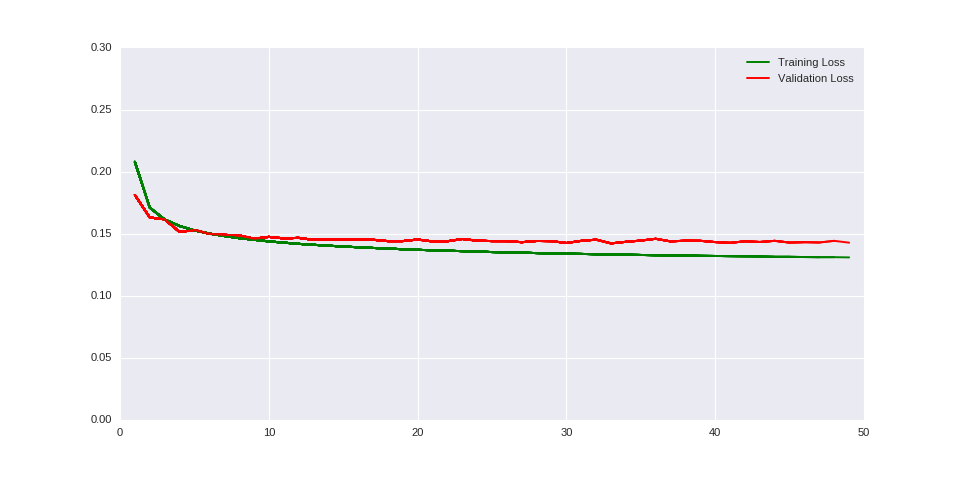

Epoch 1/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.2082

2017-04-18 22:38:10,311 : INFO : Found lower val loss for epoch 1 => 0.18146


    
1286325/1286325 [==============================] - 220s - loss: 0.2082 - val_loss: 0.1815
Epoch 2/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1713

2017-04-18 22:41:52,838 : INFO : Found lower val loss for epoch 2 => 0.1633


    
1286325/1286325 [==============================] - 222s - loss: 0.1713 - val_loss: 0.1633
Epoch 3/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1617

2017-04-18 22:45:38,634 : INFO : Found lower val loss for epoch 3 => 0.16186


    
1286325/1286325 [==============================] - 225s - loss: 0.1617 - val_loss: 0.1619
Epoch 4/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1564

2017-04-18 22:49:22,919 : INFO : Found lower val loss for epoch 4 => 0.15164


    
1286325/1286325 [==============================] - 224s - loss: 0.1564 - val_loss: 0.1516
Epoch 5/200
1286325/1286325 [==============================] - 224s - loss: 0.1529 - val_loss: 0.1532
Epoch 6/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1503

2017-04-18 22:56:53,440 : INFO : Found lower val loss for epoch 6 => 0.15015


    
1286325/1286325 [==============================] - 225s - loss: 0.1503 - val_loss: 0.1502
Epoch 7/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1484

2017-04-18 23:00:37,172 : INFO : Found lower val loss for epoch 7 => 0.1493


    
1286325/1286325 [==============================] - 223s - loss: 0.1484 - val_loss: 0.1493
Epoch 8/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1467

2017-04-18 23:04:22,264 : INFO : Found lower val loss for epoch 8 => 0.14892


    
1286325/1286325 [==============================] - 225s - loss: 0.1467 - val_loss: 0.1489
Epoch 9/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1453

2017-04-18 23:08:06,251 : INFO : Found lower val loss for epoch 9 => 0.14618


    
1286325/1286325 [==============================] - 223s - loss: 0.1453 - val_loss: 0.1462
Epoch 10/200
1286325/1286325 [==============================] - 224s - loss: 0.1440 - val_loss: 0.1477
Epoch 11/200
1286325/1286325 [==============================] - 218s - loss: 0.1430 - val_loss: 0.1465
Epoch 12/200
1286325/1286325 [==============================] - 222s - loss: 0.1421 - val_loss: 0.1469
Epoch 13/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1413

2017-04-18 23:22:59,015 : INFO : Found lower val loss for epoch 13 => 0.14526


    
1286325/1286325 [==============================] - 227s - loss: 0.1413 - val_loss: 0.1453
Epoch 14/200
1286325/1286325 [==============================] - 225s - loss: 0.1406 - val_loss: 0.1457
Epoch 15/200
1286325/1286325 [==============================] - 226s - loss: 0.1399 - val_loss: 0.1454
Epoch 16/200
1286325/1286325 [==============================] - 223s - loss: 0.1393 - val_loss: 0.1456
Epoch 17/200
1286325/1286325 [==============================] - 227s - loss: 0.1387 - val_loss: 0.1454
Epoch 18/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1383

2017-04-18 23:41:49,792 : INFO : Found lower val loss for epoch 18 => 0.14427
2017-04-18 23:41:49,793 : INFO : Validation Loss Reduced 10 times
2017-04-18 23:41:49,794 : INFO : Evaluating on Validation Data


2017-04-18 23:44:51,962 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 1.429 | Top 3: 0.972 | Top 5: 0.995 | F1 Micro: 0.789 | F1 Macro: 0.733
1286325/1286325 [==============================] - 417s - loss: 0.1383 - val_loss: 0.1443
Epoch 19/200
1286325/1286325 [==============================] - 225s - loss: 0.1377 - val_loss: 0.1443
Epoch 20/200
1286325/1286325 [==============================] - 225s - loss: 0.1372 - val_loss: 0.1456
Epoch 21/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1369

2017-04-18 23:56:17,310 : INFO : Found lower val loss for epoch 21 => 0.14401


    
1286325/1286325 [==============================] - 226s - loss: 0.1369 - val_loss: 0.1440
Epoch 22/200
1286325/1286325 [==============================] - 225s - loss: 0.1365 - val_loss: 0.1441
Epoch 23/200
1286325/1286325 [==============================] - 225s - loss: 0.1362 - val_loss: 0.1460
Epoch 24/200
1286325/1286325 [==============================] - 224s - loss: 0.1358 - val_loss: 0.1446
Epoch 25/200
1286325/1286325 [==============================] - 225s - loss: 0.1354 - val_loss: 0.1443
Epoch 26/200
1286325/1286325 [==============================] - 224s - loss: 0.1353 - val_loss: 0.1443
Epoch 27/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1350

2017-04-19 00:18:46,948 : INFO : Found lower val loss for epoch 27 => 0.1434


    
1286325/1286325 [==============================] - 224s - loss: 0.1350 - val_loss: 0.1434
Epoch 28/200
1286325/1286325 [==============================] - 225s - loss: 0.1346 - val_loss: 0.1444
Epoch 29/200
1286325/1286325 [==============================] - 225s - loss: 0.1344 - val_loss: 0.1442
Epoch 30/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1341

2017-04-19 00:30:02,046 : INFO : Found lower val loss for epoch 30 => 0.14275


    
1286325/1286325 [==============================] - 224s - loss: 0.1341 - val_loss: 0.1427
Epoch 31/200
1286325/1286325 [==============================] - 225s - loss: 0.1339 - val_loss: 0.1445
Epoch 32/200
1286325/1286325 [==============================] - 225s - loss: 0.1337 - val_loss: 0.1454
Epoch 33/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1336

2017-04-19 00:41:20,309 : INFO : Found lower val loss for epoch 33 => 0.14243


    
1286325/1286325 [==============================] - 227s - loss: 0.1336 - val_loss: 0.1424
Epoch 34/200
1286325/1286325 [==============================] - 225s - loss: 0.1333 - val_loss: 0.1437
Epoch 35/200
1286325/1286325 [==============================] - 224s - loss: 0.1331 - val_loss: 0.1447
Epoch 36/200
1286325/1286325 [==============================] - 224s - loss: 0.1329 - val_loss: 0.1461
Epoch 37/200
1286325/1286325 [==============================] - 222s - loss: 0.1327 - val_loss: 0.1440
Epoch 38/200
1286325/1286325 [==============================] - 223s - loss: 0.1326 - val_loss: 0.1446
Epoch 39/200
1286325/1286325 [==============================] - 223s - loss: 0.1324 - val_loss: 0.1445
Epoch 40/200
1286325/1286325 [==============================] - 225s - loss: 0.1323 - val_loss: 0.1435
Epoch 41/200
1286325/1286325 [==============================] - 223s - loss: 0.1322 - val_loss: 0.1429
Epoch 42/200
1286325/1286325 [==============================] - 224s - loss: 0.13

2017-04-19 01:41:01,375 : INFO : Evaluating on Training Data
2017-04-19 01:50:23,439 : INFO : Generating Training Metrics


****** Training Metrics: Cov Err: 1.344 | Top 3: 0.984 | Top 5: 0.998 | F1 Micro: 0.831 | F1 Macro: 0.796


2017-04-19 01:51:00,163 : INFO : Evaluating on Validation Data using saved best weights
2017-04-19 01:53:21,109 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 1.420 | Top 3: 0.973 | Top 5: 0.995 | F1 Micro: 0.795 | F1 Macro: 0.741


IOError: [Errno 28] No space left on device

In [35]:
%matplotlib notebook

for GLOBAL_PARAMS in GLOBAL_PARMS_TO_RUN:
    
    print '==================================== NEW PARAM SET ============================================'
    print {k:v for k,v in GLOBAL_PARAMS.items() if k != 'classifications'}
    
    classifications = GLOBAL_PARAMS['classifications']
    classifications_type = GLOBAL_PARAMS['classifications_type']
    classifier_file = TYPE_CLASSIFIER.format(classifications_type)
    
    PARTS_LEVEL = GLOBAL_PARAMS['parts_level']
    
    
    placeholder_model_name = 'doc2vec_size_{}_w_{}_type_{}_concat_{}_mean_{}_trainwords_{}_hs_{}_neg_{}_vocabsize_{}'.format(DOC2VEC_SIZE, 
                                                                DOC2VEC_WINDOW, 
                                                                'dm' if DOC2VEC_TYPE == 1 else 'pv-dbow',
                                                                DOC2VEC_CONCAT, DOC2VEC_MEAN,
                                                                DOC2VEC_TRAIN_WORDS,
                                                                DOC2VEC_HIERARCHICAL_SAMPLE,DOC2VEC_NEGATIVE_SAMPLE_SIZE,
                                                                str(DOC2VEC_MAX_VOCAB_SIZE))
    GLOBAL_VARS.DOC2VEC_MODEL_NAME = placeholder_model_name
    placeholder_model_name = os.path.join(placeholder_model_name, "epoch_{}")

    epoch = GLOBAL_PARAMS['doc2vec_epoch']

    GLOBAL_VARS.MODEL_NAME = placeholder_model_name.format(epoch)
    print GLOBAL_VARS.MODEL_NAME
    
    time.sleep(0.2)
    
    info("Loading Training Documents")
    X, y = get_training_data(classifications_type, PARTS_LEVEL)
    print X.shape
    print y.shape
    
    info("Loading Validation Documents")
    Xv, yv = get_validation_data(classifications_type, PARTS_LEVEL)
    print Xv.shape
    print yv.shape
    
    
    NN_OUTPUT_NEURONS = len(classifications)
    EARLY_STOPPER_MIN_DELTA = early_stopper_deltas[classifications_type]
    EARLY_STOPPER_PATIENCE = early_stopper_patience[classifications_type]

    NN_MAX_EPOCHS = 200
    NN_PARAM_SAMPLE_SEED = 1234

    NN_BATCH_SIZE = GLOBAL_PARAMS['nn_batch_size']

    MODEL_VERBOSITY = 1

    NN_OPTIMIZER = 'rmsprop'
    # NN_OPTIMIZER = 'adam'

    to_skip = []

    load_existing_results = True
    save_results = True


    np.random.seed(NN_SEED)
    
    
    
    ################################################################################
    ############### Actual Training


    # load previous finshed results so we dont redo them
    param_results_dict = {}
    
    param_results_path = os.path.join(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME, 
                                                   NN_PARAMETER_SEARCH_PREFIX.format(classifications_type, PARTS_LEVEL, NN_BATCH_SIZE)))
        
    if load_existing_results:
        if os.path.exists(param_results_path):
            info('Loading Previous results from {}'.format(param_results_path))
            param_results_dict = pickle.load(open(param_results_path))
        else:
            info('No Previous results exist in {}'.format(param_results_path))

    ensure_disk_location_exists(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME))

    start_time = time.time()
    lstm_output_size = GLOBAL_PARAMS['lstm_output_size']
    w_dropout_do = GLOBAL_PARAMS['lstm_w_dropout']
    u_dropout_do = GLOBAL_PARAMS['lstm_u_dropout']
    stack_layers = GLOBAL_PARAMS['lstm_stack_layers']
    conv_size = GLOBAL_PARAMS['lstm_conv_size']
    conv_filter_length = GLOBAL_PARAMS['lstm_conv_filter_length']
    conv_max_pooling_length = GLOBAL_PARAMS['lstm_max_pooling_length']

    GLOBAL_VARS.NN_MODEL_NAME = 'lstm_optimizer_{}_size_{}_w-drop_{}_u-drop_{}_stack_{}_conv_{}'.format(NN_OPTIMIZER,
        lstm_output_size,  w_dropout_do, u_dropout_do, stack_layers, str(conv_size)
    )
    if conv_size:
        GLOBAL_VARS.NN_MODEL_NAME += '_conv-filter-length_{}_max-pooling-size_{}'.format(conv_filter_length, 
                                                                                         conv_max_pooling_length)

    if GLOBAL_VARS.NN_MODEL_NAME in param_results_dict.keys() or GLOBAL_VARS.NN_MODEL_NAME in to_skip:
        print "skipping: {}".format(GLOBAL_VARS.NN_MODEL_NAME)
        continue

    info('***************************************************************************************')
    info(GLOBAL_VARS.NN_MODEL_NAME)

    # creating the actual keras model
    model = create_keras_rnn_model(DOC2VEC_SIZE, NN_OUTPUT_NEURONS, 
                                  lstm_output_size, w_dropout_do, u_dropout_do, stack_layers, conv_size, 
                                   conv_filter_length, conv_max_pooling_length)
    model.summary()

    # callbacks for early stopping and for generating validation metrics
    early_stopper = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=EARLY_STOPPER_MIN_DELTA, \
                                                  patience=EARLY_STOPPER_PATIENCE, verbose=1, mode='auto')
    metrics_callback = MetricsCallback()


    # Model Fitting
    %time history = model.fit(x=X, y=y, validation_data=(Xv,yv), batch_size=NN_BATCH_SIZE, \
                              nb_epoch=NN_MAX_EPOCHS, verbose=MODEL_VERBOSITY, \
                              callbacks=[early_stopper, metrics_callback])
    
    
#     time.sleep(0.2)
#     info('Evaluating on Training Data')
#     yp = model.predict(X) # get raw probability for predicted labels
#     yp_binary = get_binary_0_5(yp) # use 0.5 as threshold for setting labels to 0 or 1
#     #print yvp
#     info('Generating Training Metrics')
#     training_metrics = get_metrics(y, yp, yp_binary)
#     print "****** Training Metrics: Cov Err: {:.3f} | Top 3: {:.3f} | Top 5: {:.3f} | F1 Micro: {:.3f} | F1 Macro: {:.3f}".format(
#     training_metrics['coverage_error'], training_metrics['top_3'], training_metrics['top_5'], 
#     training_metrics['f1_micro'], training_metrics['f1_macro'])
    
    
    time.sleep(0.2)
    info('Evaluating on Validation Data using saved best weights')
    model.set_weights(metrics_callback.best_weights)
    yvp = model.predict(Xv) # get raw probability for predicted labels
    yvp_binary = get_binary_0_5(yvp) # use 0.5 as threshold for setting labels to 0 or 1
    #print yvp
    info('Generating Validation Metrics')
    validation_metrics = get_metrics(yv, yvp, yvp_binary)
    print "****** Validation Metrics: Cov Err: {:.3f} | Top 3: {:.3f} | Top 5: {:.3f} | F1 Micro: {:.3f} | F1 Macro: {:.3f}".format(
        validation_metrics['coverage_error'], validation_metrics['top_3'], validation_metrics['top_5'], 
        validation_metrics['f1_micro'], validation_metrics['f1_macro'])
    best_validation_metrics = validation_metrics
    
    time.sleep(0.2)
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME] = dict()
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['best_validation_metrics'] = best_validation_metrics
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['epochs'] = len(history.history['val_loss'])
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['best_weights'] = metrics_callback.best_weights
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['best_val_loss'] = metrics_callback.best_val_loss
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['training_loss'] = metrics_callback.losses
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['validation_loss'] = metrics_callback.val_losses

    duration = time.time() - start_time
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['duration'] =  duration

    del history, metrics_callback, model

    if save_results:
        if load_existing_results:
            if os.path.exists(param_results_path):
                info('Loading Previous results from {}'.format(param_results_path))
                loaded_param_results_dict = pickle.load(open(param_results_path))
                param_results_dict.update(loaded_param_results_dict)

        pickle.dump(param_results_dict, open(param_results_path, 'w'))
        

In [23]:

time.sleep(0.2)
info('Evaluating on Validation Data using saved best weights')
model.set_weights(metrics_callback.best_weights)
yvp = model.predict(Xv) # get raw probability for predicted labels
yvp_binary = get_binary_0_5(yvp) # use 0.5 as threshold for setting labels to 0 or 1
#print yvp
info('Generating Validation Metrics')
validation_metrics = get_metrics(yv, yvp, yvp_binary)
print "****** Validation Metrics: Cov Err: {:.3f} | Top 3: {:.3f} | Top 5: {:.3f} | F1 Micro: {:.3f} | F1 Macro: {:.3f}".format(
    validation_metrics['coverage_error'], validation_metrics['top_3'], validation_metrics['top_5'], 
    validation_metrics['f1_micro'], validation_metrics['f1_macro'])
best_validation_metrics = validation_metrics


2017-04-13 19:29:00,369 : INFO : Evaluating on Validation Data using saved best weights
2017-04-13 19:34:08,795 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 1.357 | Top 3: 0.982 | Top 5: 0.997 | F1 Micro: 0.827 | F1 Macro: 0.784


In [25]:
param_results_dict[GLOBAL_VARS.NN_MODEL_NAME] = dict()
param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['best_validation_metrics'] = best_validation_metrics
# param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['epochs'] = len(history.history['val_loss'])
param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['best_weights'] = metrics_callback.best_weights
param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['best_val_loss'] = metrics_callback.best_val_loss
param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['training_loss'] = metrics_callback.losses
param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['validation_loss'] = metrics_callback.val_losses


In [26]:
pickle.dump(param_results_dict, open('/mnt/data/shalaby/sections_lstm.pkl', 'w'))

## Testing

In [20]:
classifications = sections
classifications_type = 'sections'

In [21]:
TEST_METRICS_FILENAME = '{}_level_{}_lstm_test_metrics_dict.pkl'

In [22]:
DOC2VEC_EPOCH = 8

In [23]:
placeholder_model_name = 'doc2vec_size_{}_w_{}_type_{}_concat_{}_mean_{}_trainwords_{}_hs_{}_neg_{}_vocabsize_{}'.format(DOC2VEC_SIZE, 
                                                            DOC2VEC_WINDOW, 
                                                            'dm' if DOC2VEC_TYPE == 1 else 'pv-dbow',
                                                            DOC2VEC_CONCAT, DOC2VEC_MEAN,
                                                            DOC2VEC_TRAIN_WORDS,
                                                            DOC2VEC_HIERARCHICAL_SAMPLE,DOC2VEC_NEGATIVE_SAMPLE_SIZE,
                                                            str(DOC2VEC_MAX_VOCAB_SIZE))
GLOBAL_VARS.DOC2VEC_MODEL_NAME = placeholder_model_name
placeholder_model_name = os.path.join(placeholder_model_name, "epoch_{}")

epoch = DOC2VEC_EPOCH

GLOBAL_VARS.MODEL_NAME = placeholder_model_name.format(epoch)
print GLOBAL_VARS.MODEL_NAME

doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8


In [24]:
NN_BATCH_SIZE = 4096
NN_OPTIMIZER = 'rmsprop'

In [25]:
PARTS_LEVEL = 2

In [26]:
param_results_path = os.path.join(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME, 
                                           NN_PARAMETER_SEARCH_PREFIX.format(classifications_type, PARTS_LEVEL, NN_BATCH_SIZE)))
param_results_dict = pickle.load(open(param_results_path))

In [27]:
Xt, yt = get_test_data(classifications_type, PARTS_LEVEL)

2017-04-18 21:28:07,313 : INFO : Loading Test Data from file


In [28]:
NN_OUTPUT_NEURONS = len(classifications)
NN_INPUT_NEURONS = Xt.shape[1]

In [29]:
param_results_dict.keys()

['lstm_optimizer_rmsprop_size_1000_w-drop_0.5_u-drop_0.5_stack_2_conv_None',
 'lstm_optimizer_rmsprop_size_1000_w-drop_0.5_u-drop_0.5_stack_3_conv_None',
 'lstm_optimizer_rmsprop_size_1000_w-drop_0.5_u-drop_0.5_stack_1_conv_None']

In [30]:
lstm_output_size = 1000
w_dropout_do = 0.5
u_dropout_do = 0.5
stack_layers = 3
conv_size = None
conv_filter_length = None
conv_max_pooling_length = None

GLOBAL_VARS.NN_MODEL_NAME = 'lstm_optimizer_{}_size_{}_w-drop_{}_u-drop_{}_stack_{}_conv_{}'.format(NN_OPTIMIZER,
    lstm_output_size,  w_dropout_do, u_dropout_do, stack_layers, str(conv_size)
)
if conv_size:
    GLOBAL_VARS.NN_MODEL_NAME += '_conv-filter-length_{}_max-pooling-size_{}'.format(conv_filter_length, 
                                                                                     conv_max_pooling_length)
                                                                                     
if GLOBAL_VARS.NN_MODEL_NAME not in param_results_dict.keys():
    print "Can't find model: {}".format(GLOBAL_VARS.NN_MODEL_NAME)
    raise Exception()

test_metrics_dict = {}
test_metrics_path = os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME, 
                                            TEST_METRICS_FILENAME.format(classifications_type, PARTS_LEVEL))
if os.path.exists(test_metrics_path):
    test_metrics_dict =  pickle.load(open(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME, 
                                            TEST_METRICS_FILENAME.format(classifications_type, PARTS_LEVEL))))
    if GLOBAL_VARS.NN_MODEL_NAME in test_metrics_dict.keys():
        print "Test metrics already exist for: {}".format(GLOBAL_VARS.NN_MODEL_NAME)
        test_metrics = test_metrics_dict[GLOBAL_VARS.NN_MODEL_NAME]
        print "** Test Metrics: Cov Err: {:.3f}, Avg Labels: {:.3f}, \n\t\t Top 1: {:.3f}, Top 3: {:.3f}, Top 5: {:.3f}, \n\t\t F1 Micro: {:.3f}, F1 Macro: {:.3f}, Total Pos: {:,d}".format(
            test_metrics['coverage_error'], test_metrics['average_num_of_labels'], 
            test_metrics['top_1'], test_metrics['top_3'], test_metrics['top_5'], 
            test_metrics['f1_micro'], test_metrics['f1_macro'], test_metrics['total_positive'])
        raise Exception()
        
info('***************************************************************************************')
info(GLOBAL_VARS.NN_MODEL_NAME)

# creating the actual keras model
model = create_keras_rnn_model(DOC2VEC_SIZE, NN_OUTPUT_NEURONS, 
                              lstm_output_size, w_dropout_do, u_dropout_do, stack_layers, conv_size, 
                               conv_filter_length, conv_max_pooling_length)
model.summary()

# get model best weights
# weights = param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['metrics_callback'].best_weights
weights = param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['best_weights']
model.set_weights(weights)

info('Evaluating on Test Data using best weights')
ytp = model.predict(Xt)
ytp_binary = get_binary_0_5(ytp)
#print yvp
info('Generating Test Metrics')
test_metrics = get_metrics(yt, ytp, ytp_binary)
print "** Test Metrics: Cov Err: {:.3f}, Avg Labels: {:.3f}, \n\t\t Top 1: {:.3f}, Top 3: {:.3f}, Top 5: {:.3f}, \n\t\t F1 Micro: {:.3f}, F1 Macro: {:.3f}, Total Pos: {:,d}".format(
    test_metrics['coverage_error'], test_metrics['average_num_of_labels'], 
    test_metrics['top_1'], test_metrics['top_3'], test_metrics['top_5'], 
    test_metrics['f1_micro'], test_metrics['f1_macro'], test_metrics['total_positive'])

ensure_disk_location_exists(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME))

test_metrics_dict[GLOBAL_VARS.NN_MODEL_NAME] = test_metrics
pickle.dump(test_metrics_dict, open(test_metrics_path, 'w'))

# pickle.dump(test_metrics, open(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME, 
#                                             TEST_METRICS_FILENAME.format(classifications_type, PARTS_LEVEL)), 'w'))


2017-04-18 21:28:14,579 : INFO : ***************************************************************************************
2017-04-18 21:28:14,580 : INFO : lstm_optimizer_rmsprop_size_1000_w-drop_0.5_u-drop_0.5_stack_3_conv_None


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lstm_1000_w-drop_0.5_u-drop_0.5_ (None, None, 1000)    4804000     lstm_input_1[0][0]               
____________________________________________________________________________________________________
lstm_1000_w-drop_0.5_u-drop_0.5_ (None, None, 1000)    8004000     lstm_1000_w-drop_0.5_u-drop_0.5_l
____________________________________________________________________________________________________
lstm_1000_w-drop_0.5_u-drop_0.5_ (None, 1000)          8004000     lstm_1000_w-drop_0.5_u-drop_0.5_l
____________________________________________________________________________________________________
sigmoid_output (Dense)           (None, 8)             8008        lstm_1000_w-drop_0.5_u-drop_0.5_l


2017-04-18 21:28:18,468 : INFO : Evaluating on Test Data using best weights


Total params: 20,820,008
Trainable params: 20,820,008
Non-trainable params: 0
____________________________________________________________________________________________________


2017-04-18 21:39:42,230 : INFO : Generating Test Metrics


** Test Metrics: Cov Err: 1.360, Avg Labels: 1.150, 
		 Top 1: 0.862, Top 3: 0.981, Top 5: 0.997, 
		 F1 Micro: 0.824, F1 Macro: 0.781, Total Pos: 441,003


In [32]:
print "** Test Metrics: Cov Err: {:.3f}, Avg Labels: {:.3f}, \n\t\t Top 1: {:.3f}, Top 3: {:.3f}, Top 5: {:.3f}, \n\t\t F1 Micro: {:.3f}, F1 Macro: {:.3f}, Total Pos: {:,d}".format(
    test_metrics['coverage_error'], test_metrics['average_num_of_labels'], 
    test_metrics['top_1'], test_metrics['top_3'], test_metrics['top_5'], 
    test_metrics['f1_micro'], test_metrics['f1_macro'], test_metrics['total_positive'])


** Test Metrics: Cov Err: 6.531, Avg Labels: 1.340, 
		 Top 1: 0.606, Top 3: 0.749, Top 5: 0.830, 
		 F1 Micro: 0.559, F1 Macro: 0.186, Total Pos: 370,180
